In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))
print("Data Imported")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Data Imported


In [ ]:
!pip install torch_snippets torch_summary

In [23]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import torch
import cv2

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [25]:
DIR = "../input/human-action-recognition-har-dataset/Human Action Recognition/"
TRAIN_DIR = f"{DIR}train"
TRAIN_VAL_DF = f"{DIR}Training_set.csv"

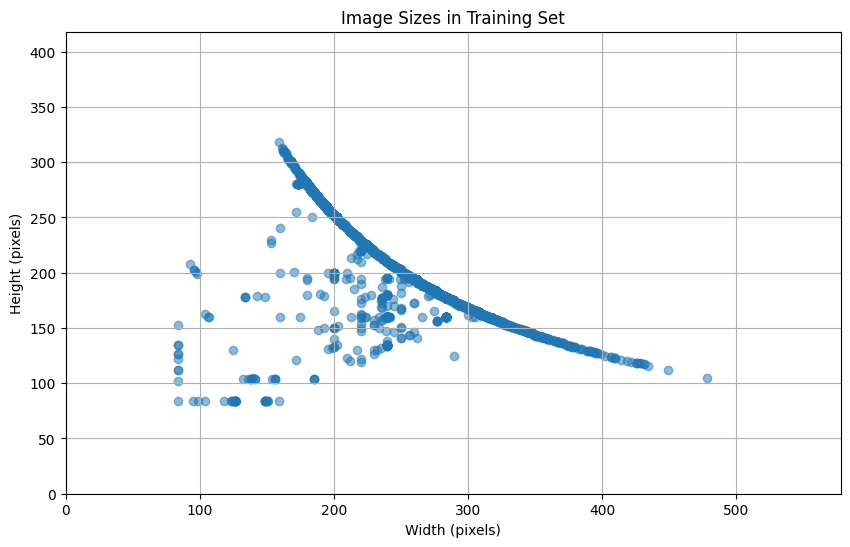

In [26]:
widths = []
heights = []

# Iterate over images in the training directory
for filename in os.listdir(TRAIN_DIR):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
        img_path = os.path.join(TRAIN_DIR, filename)
        img = cv2.imread(img_path)
        
        if img is not None:
            height, width, _ = img.shape
            widths.append(width)
            heights.append(height)

# Create a scatter plot of image sizes
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Image Sizes in Training Set')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.xlim(0, max(widths) + 100)  # Adding a bit of padding
plt.ylim(0, max(heights) + 100)  # Adding a bit of padding
plt.grid()
plt.show()

In [27]:
print(np.mean(widths))
print(np.mean(heights))

260.379652408539
196.57439885723355


In [28]:
print(np.median(widths))
print(np.median(heights))

275.0
183.0


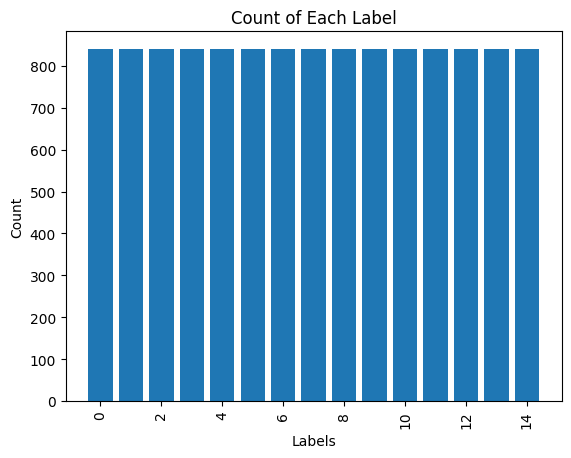

Label Mapping: {'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}


In [29]:
df = pd.read_csv(TRAIN_VAL_DF)

# Convert 'label' to categorical
df['label'] = df['label'].astype('category')

# Create a mapping from original labels to encoded labels
label_mapping = {label: code for code, label in enumerate(df['label'].cat.categories)}

# Encode the labels
df['label'] = df['label'].cat.codes

# Ensure the labels are between 0 and 14
if df['label'].max() > 14:
    raise ValueError("Label values exceed the range 0 to 14. Adjust your labels accordingly.")

# Group by the encoded labels and count occurrences
agg_labels = df.groupby('label').agg({'label': 'count'}).rename(columns={'label': 'count'})

# Plotting the count of each label
plt.bar(agg_labels.index, agg_labels['count'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.xticks(rotation=90)
plt.show()

print("Label Mapping:", label_mapping)

In [30]:
class_names = {num : class_name for class_name, num in label_mapping.items()}

In [31]:
print(class_names)

{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


In [59]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop((1000, 1000)),
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((299, 299)),
        # transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [60]:
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = self.annotations[self.annotations['filename'].apply(
            lambda x: os.path.isfile(os.path.join(self.root_dir, x)))]

        # print(f"Images found: {len(self.annotations)}")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])  # Ensure label is integer

        if self.transform:
            image = self.transform(image)

        return image, label

In [116]:
train_dataset = CustomImageDataset(df = df, root_dir=TRAIN_DIR, transform=data_transforms['train'])
train_set, val_set = train_test_split(train_dataset.annotations, test_size=0.2, random_state=42)

train_dataset.annotations = train_set.reset_index(drop=True)
val_dataset = CustomImageDataset(df = df, root_dir=TRAIN_DIR, transform=data_transforms['val'])
val_dataset.annotations = val_set.reset_index(drop=True)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=True)

In [117]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [118]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    plt.title(title, fontsize=14)
    plt.axis('off')

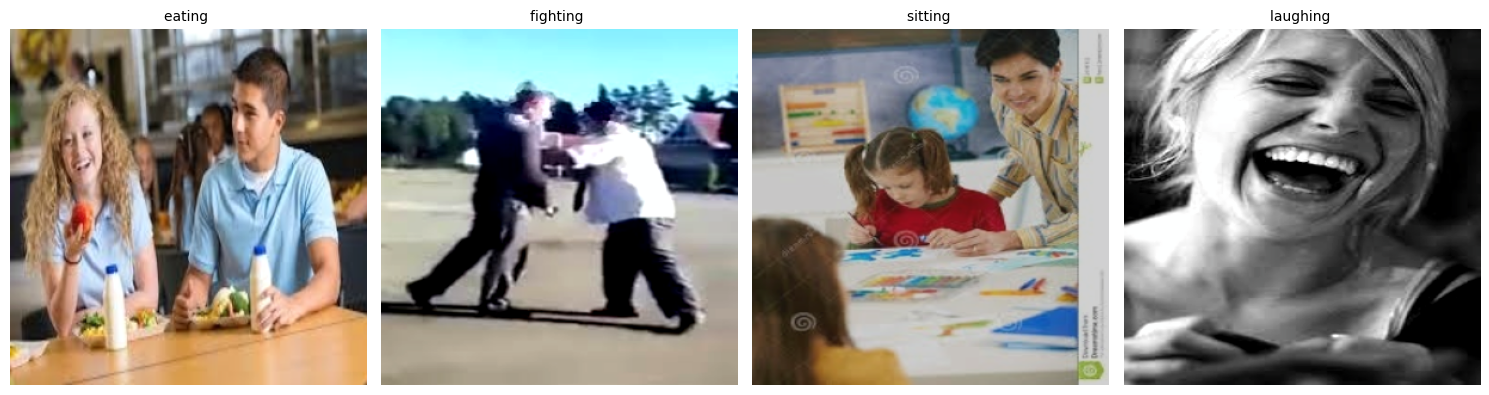

In [119]:
inputs, classes = next(iter(train_loader))
classes = list(classes)
num_images = inputs.size(0)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
titles = [f"{class_names[int(classes[i])]} " for i in range(num_images)]
for ax, img, title in zip(axes, inputs, titles):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [120]:
num_epochs = 30

In [ ]:
model_resnet = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs_resnet, 15)  # 15 classes for your problem
model_resnet = model_resnet.to(device)

# Set up the criterion (loss function) and optimizer
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

# DataLoader for training and validation
dataloaders_resnet = {'train': train_loader, 'val': val_loader}

# Start training the ResNet model
start_time_resnet = time.time()

train_loss_resnet = []
val_loss_resnet = []
val_acc_resnet = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_resnet.train()
        else:
            model_resnet.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders_resnet[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer_resnet.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs_resnet = model_resnet(inputs)
                _, preds_resnet = torch.max(outputs_resnet, 1)
                loss_resnet = criterion_resnet(outputs_resnet, labels)

                if phase == 'train':
                    loss_resnet.backward()
                    optimizer_resnet.step()

            running_loss += loss_resnet.item() * inputs.size(0)
            running_corrects += torch.sum(preds_resnet == labels.data)

        epoch_loss_resnet = running_loss / len(dataloaders_resnet[phase].dataset)
        epoch_acc_resnet = running_corrects.double() / len(dataloaders_resnet[phase].dataset)

        if phase == 'train':
            train_loss_resnet.append(epoch_loss_resnet)
            print(f'Train Loss: {epoch_loss_resnet:.4f} Acc: {epoch_acc_resnet:.4f}')
        else:
            val_loss_resnet.append(epoch_loss_resnet)
            val_acc_resnet.append(epoch_acc_resnet)
            print(f'Val Loss: {epoch_loss_resnet:.4f} Acc: {epoch_acc_resnet:.4f}')

    scheduler_resnet.step()

time_elapsed_resnet = time.time() - start_time_resnet
print(f'ResNet Training complete in {time_elapsed_resnet // 60:.0f}m {time_elapsed_resnet % 60:.0f}s')

# Save the ResNet model
torch.save(model_resnet.state_dict(), "resnet_model.pth")

Epoch 0/29
----------
Train Loss: 2.7020 Acc: 0.0883
Val Loss: 2.5748 Acc: 0.1464
Epoch 1/29
----------
Train Loss: 2.5923 Acc: 0.1285
Val Loss: 2.9106 Acc: 0.1500
Epoch 2/29
----------
Train Loss: 2.5229 Acc: 0.1562
Val Loss: 2.5649 Acc: 0.2008
Epoch 3/29
----------
Train Loss: 2.4492 Acc: 0.1805
Val Loss: 2.3706 Acc: 0.2095
Epoch 4/29
----------
Train Loss: 2.3646 Acc: 0.2123
Val Loss: 2.3136 Acc: 0.2571
Epoch 5/29
----------
Train Loss: 2.2693 Acc: 0.2427
Val Loss: 2.3371 Acc: 0.2433
Epoch 6/29
----------
Train Loss: 2.1944 Acc: 0.2741
Val Loss: 2.2522 Acc: 0.2865
Epoch 7/29
----------
Train Loss: 2.0336 Acc: 0.3340
Val Loss: 2.0663 Acc: 0.3278
Epoch 8/29
----------
Train Loss: 2.0017 Acc: 0.3476
Val Loss: 2.0274 Acc: 0.3532
Epoch 9/29
----------
Train Loss: 1.9550 Acc: 0.3602
Val Loss: 2.0045 Acc: 0.3643
Epoch 10/29
----------
Train Loss: 1.9280 Acc: 0.3727
Val Loss: 1.9823 Acc: 0.3667
Epoch 11/29
----------
Train Loss: 1.9071 Acc: 0.3771
Val Loss: 2.0034 Acc: 0.3631
Epoch 12/29
--

In [ ]:
model_vgg = models.vgg16(weights='IMAGENET1K_V1')
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, 15)  # 15 classes for your problem
model_vgg = model_vgg.to(device)

# Set up the criterion (loss function) and optimizer
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=0.001)
scheduler_vgg = optim.lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

# DataLoader for training and validation
dataloaders_vgg = {'train': train_loader, 'val': val_loader}

# Start training the VGG model
start_time_vgg = time.time()

train_loss_vgg = []
val_loss_vgg = []
val_acc_vgg = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_vgg.train()
        else:
            model_vgg.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders_vgg[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer_vgg.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs_vgg = model_vgg(inputs)
                _, preds_vgg = torch.max(outputs_vgg, 1)
                loss_vgg = criterion_vgg(outputs_vgg, labels)

                if phase == 'train':
                    loss_vgg.backward()
                    optimizer_vgg.step()

            running_loss += loss_vgg.item() * inputs.size(0)
            running_corrects += torch.sum(preds_vgg == labels.data)

        epoch_loss_vgg = running_loss / len(dataloaders_vgg[phase].dataset)
        epoch_acc_vgg = running_corrects.double() / len(dataloaders_vgg[phase].dataset)

        if phase == 'train':
            train_loss_vgg.append(epoch_loss_vgg)
            print(f'Train Loss: {epoch_loss_vgg:.4f} Acc: {epoch_acc_vgg:.4f}')
        else:
            val_loss_vgg.append(epoch_loss_vgg)
            val_acc_vgg.append(epoch_acc_vgg)
            print(f'Val Loss: {epoch_loss_vgg:.4f} Acc: {epoch_acc_vgg:.4f}')

    scheduler_vgg.step()

time_elapsed_vgg = time.time() - start_time_vgg
print(f'VGG Training complete in {time_elapsed_vgg // 60:.0f}m {time_elapsed_vgg % 60:.0f}s')

# Save the VGG model
torch.save(model_vgg.state_dict(), "vgg_model.pth")

In [ ]:
# Initialize the Inception model
model_inception = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)
num_ftrs_inception = model_inception.fc.in_features
model_inception.fc = nn.Linear(num_ftrs_inception, 15)  # 15 classes for your problem
model_inception = model_inception.to(device)

# Set up the criterion (loss function) and optimizer
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.Adam(model_inception.parameters(), lr=0.001)
scheduler_inception = optim.lr_scheduler.StepLR(optimizer_inception, step_size=7, gamma=0.1)

# DataLoader for training and validation
dataloaders_inception = {'train': train_loader, 'val': val_loader}

# Start training the Inception model
start_time_inception = time.time()

train_loss_inception = []
val_loss_inception = []
val_acc_inception = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_inception.train()
        else:
            model_inception.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders_inception[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer_inception.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                # Forward pass
                outputs_inception = model_inception(inputs)

                # If aux_logits is present, outputs_inception will be a tuple (logits, aux_logits)
                if isinstance(outputs_inception, tuple):
                    logits = outputs_inception[0]  # Main logits
                else:
                    logits = outputs_inception  # No aux_logits, use the main logits directly

                # Get predictions
                _, preds_inception = torch.max(logits, 1)

                # Calculate loss
                loss_inception = criterion_inception(logits, labels)

                if phase == 'train':
                    loss_inception.backward()
                    optimizer_inception.step()

            running_loss += loss_inception.item() * inputs.size(0)
            running_corrects += torch.sum(preds_inception == labels.data)

        epoch_loss_inception = running_loss / len(dataloaders_inception[phase].dataset)
        epoch_acc_inception = running_corrects.double() / len(dataloaders_inception[phase].dataset)

        if phase == 'train':
            train_loss_inception.append(epoch_loss_inception)
            print(f'Train Loss: {epoch_loss_inception:.4f} Acc: {epoch_acc_inception:.4f}')
        else:
            val_loss_inception.append(epoch_loss_inception)
            val_acc_inception.append(epoch_acc_inception)
            print(f'Val Loss: {epoch_loss_inception:.4f} Acc: {epoch_acc_inception:.4f}')

    scheduler_inception.step()

time_elapsed_inception = time.time() - start_time_inception
print(f'Inception Training complete in {time_elapsed_inception // 60:.0f}m {time_elapsed_inception % 60:.0f}s')

# Save the Inception model
torch.save(model_inception.state_dict(), "inception_model.pth")

In [ ]:
import matplotlib.pyplot as plt
import torch

# Create a dictionary to store results for all models
results = {
    'resnet': {
        'train_loss': train_loss_resnet,
        'val_loss': val_loss_resnet,
        'val_acc': val_acc_resnet
    },
    'vgg': {
        'train_loss': train_loss_vgg,
        'val_loss': val_loss_vgg,
        'val_acc': val_acc_vgg
    },
    'inception': {
        'train_loss': train_loss_inception,
        'val_loss': val_loss_inception,
        'val_acc': val_acc_inception
    }
}

# Plotting Train and Validation Losses for all models
plt.figure(figsize=(12, 6))
for model_name, result in results.items():
    plt.plot(result['train_loss'], label=f'{model_name} Train Loss')
    plt.plot(result['val_loss'], label=f'{model_name} Val Loss', linestyle='--')
plt.title("Train and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting Validation Accuracy for all models
plt.figure(figsize=(12, 6))
for model_name, result in results.items():
    val_acc = result['val_acc']
    
    # Ensure that the accuracy tensors are moved to the CPU before plotting
    # val_acc = val_acc.cpu()
    if isinstance(val_acc, list):
        val_acc = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in val_acc]
    else:
        if isinstance(val_acc, torch.Tensor):
            val_acc = val_acc.cpu().numpy()
    # val_acc = np.array(val_acc)
    # Plot the validation accuracy
    plt.plot(val_acc, label=f'{model_name} Val Accuracy')
plt.title("Validation Accuracy for all models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [73]:
def initialize_model(model_name, num_classes, feature_extract=True):
    model = None
    if model_name == "resnet":
        model = models.resnet50(weights='IMAGENET1K_V1')
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "vgg":
        model = models.vgg16(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "inception":
        model = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [76]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=1):
    since = time.time()
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    logits = outputs[0]
                    
                    _, preds = torch.max(logits, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)  # Loss * batch size
                running_corrects += torch.sum(preds == labels.data)

            # Calculate the loss and accuracy for this epoch and phase
            epoch_loss = running_loss / len(dataloaders[phase].dataset)  # Average loss for the phase
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)  # Accuracy for the phase

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
        if scheduler:
            scheduler.step()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    return train_loss_history, val_loss_history, val_acc_history

In [77]:
models_to_train = ["resnet", "vgg", "inception"]
num_epochs = 10
results = {}

In [78]:
for model_name in models_to_train:
    print(f"Training {model_name} model...")
    model = initialize_model(model_name, num_classes=15)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    dataloaders = {'train': train_loader, 'val': val_loader}

    train_loss, val_loss, val_acc = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs)
    results[model_name] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

    # Save the model
    torch.save(model.state_dict(), f"{model_name}_model.pth")

Training resnet model...
Epoch 0/9
----------


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
for model_name, result in results.items():
    print(f"{model_name} - Best Val Accuracy: {max(result['val_acc']):.4f}")

    plt.plot(result['val_acc'], label=f"{model_name} - Validation Accuracy")
    plt.plot(result['val_loss'], label=f"{model_name} - Validation Loss")

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.title('Model Performance Comparison')
plt.show()